------------------------------------------------------------------------------------------------------------------------------------------------------

## CROSSTALK NOTEBOOK


##### PLEASE! When you are done with the tutorial, move to the ```notebooks``` folder to start your own analysis 
 In this way, you will be able to keep the tutorial as a reference for future use (or others to use it).

------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import sys; sys.path.insert(0, '../'); from lib import *;

Welcome to JupyROOT 6.28/00
You have latex installed!. Applying default configuration (tex=True)


In [2]:
# Set options for general visualitation
OPT  = {
    "MICRO_SEC":   True,                # Time in microseconds (True/False)
    "NORM":        False,               # Runs can be displayed normalised (True/False)
    "ALIGN":       True,                # Aligns waveforms in peaktime (True/False)
    "LOGY":        False,               # Runs can be displayed in logy (True/False)
    "SHOW_AVE":    "",                  # If computed, vis will show average (AveWvf,AveWvfSPE,etc.)
    "SHOW_PARAM":  False,               # Print terminal information (True/False)
    "CHARGE_KEY":  "ChargeAveRange",    # Select charge info to be displayed. Default: "ChargeAveRange" (if computed)
    "PEAK_FINDER": False,               # Finds possible peaks in the window (True/False)
    "LEGEND":      True,                # Shows plot legend (True/False)
    "SHOW":        True
    }

In [3]:
info           = read_input_file("TUTORIAL") # Read input file
calib_runs     = [ 1]                        # Calibration runs
laser_runs     = [ 9]                        # Laser runs
alpha_runs     = [25]                        # Alpha runs
muons_runs     = [29]                        # Muons runs
noise_runs     = [128]                       # Noise runs

channels = [0,6]

In [4]:
my_runs_calib = load_npy(np.asarray(calib_runs).astype(int),np.asarray(channels).astype(int),preset="EVA",info=info,compressed=True)

time_wvf = np.arange(len(my_runs_calib[calib_runs[0]][channels[0]]["AnaAveWvf"][0]))*4e-9
time_all = np.arange(len(my_runs_calib[calib_runs[0]][channels[0]]["TimeStamp"]))*4e-9

load_npy --> DONE!

load_npy --> DONE!



# Vinogradov model (Poisson+Binomial distribution)

In [7]:
def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    return popt,fit_y, chi_squared


FOUNDED PEAKS: (array([30, 56]), {'peak_heights': array([1179.,  361.]), 'prominences': array([1179.,  145.]), 'left_bases': array([ 6, 48]), 'right_bases': array([195, 195]), 'widths': array([14.23659122,  7.84615385]), 'width_heights': array([589.5, 288.5]), 'left_ips': array([24.17549669, 50.75      ]), 'right_ips': array([38.41208791, 58.59615385])})
Amplitude: [1179.  361.]
Sigma:  [0.5 0.5]
PNs:  [0.76558442 0.23441558]
PNs_error:  [0.03153198 0.01744809]
Initial vars: -0.14628821563976135 	 0.2671157948703039
[-0.05714286  0.76      ] [0, 1]
Fitted vars:  [-0.14628822  0.26711579]
Rel Error:  [-inf  inf]


/home/laura/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning:

Covariance of the parameters could not be estimated



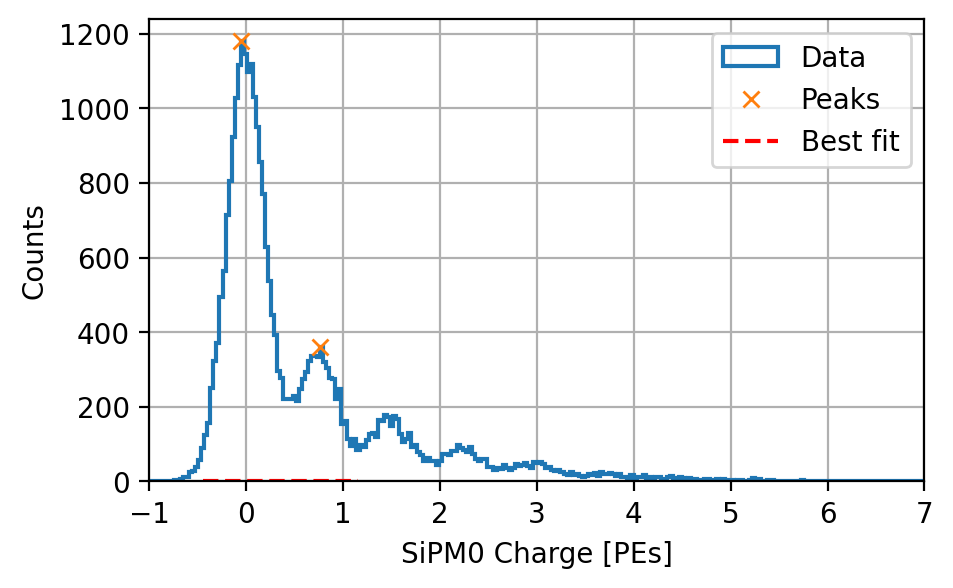

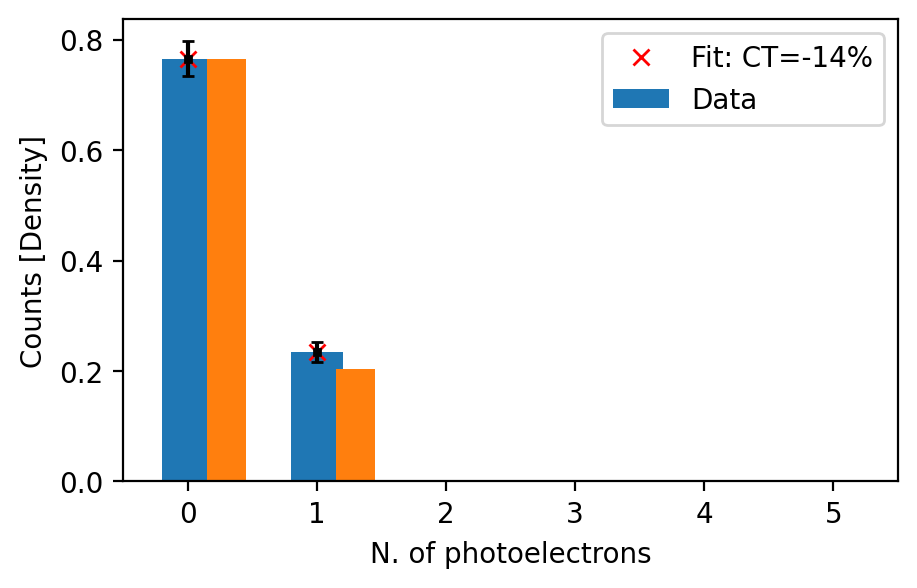

In [12]:
# file_CT=[];
debug = True
factor2PE = 1/3.48e2 # GAIN IN ADC*ticks TO CONVER CHARGE INTO PE
my_bins   = 350
my_range  = [-1,10]

#get counts
counts,bins= np.histogram(my_runs_calib[calib_runs[0]][0]["AnaChargePedRange1"]*factor2PE,my_bins,my_range);#need to convert to PE
# plt.hist(my_runs_calib[calib_runs[0]][0]["AnaChargePedRange1"]*factor2PE,bins=my_bins,histtype="step",label="Data",linewidth=1.5)

#find peaks
peaks = find_peaks(counts,height=150,width=4,distance=int(my_bins/((my_range[1]-my_range[0])*1.2))  )
print("FOUNDED PEAKS:", peaks)

# right limit:(supossing same space between peaks, prevents adding more gaussians that the ones considered to be fitted)
r_lim = peaks[0][-1]+ int (((peaks[0][-1]-peaks[0][-2]))/2)
l_lim = peaks[0][ 0]- int (((peaks[0][ 1]-peaks[0][ 0]))/2)

params       = np.zeros(len(peaks[0])*3)
params[0::3] = peaks[1]["peak_heights"]
params[1::3] = bins[peaks[0]]
params[2::3] = 0.5

my_vars,fit_y,qs = fit_gaussians(bins[:-1][l_lim:r_lim],counts[l_lim:r_lim],params)


# 1st Plot: gaussian fits
plt.figure(dpi=200,figsize=(5,3))
plt.hist(my_runs_calib[calib_runs[0]][0]["AnaChargePedRange1"]*factor2PE,bins=Bins,range=r,histtype="step",label="Data",linewidth=1.5)
plt.xlim([-1,7]) 
plt.plot(bins[peaks[0]],peaks[1]["peak_heights"],"x",label="Peaks")
plt.plot(bins[:-1][l_lim:r_lim] +(bins[1]-bins[0])/2  ,fit_y,'--',color="red",label="Best fit")        
plt.legend(fontsize=10)
plt.xlabel(my_runs_calib[calib_runs[0]][0]["Label"] +" Charge [PEs]")
plt.ylabel("Counts")
plt.grid()

#Compute Gaussian areas
Amp=vars[0::3]
sigma=np.abs(vars[2::3])

#prob is proportional to A*sigma (sqrt(2pi))
PNs=Amp*sigma/sum(Amp*sigma)

#assuming error propt to sqrt(N)
PNs_err=(Amp*sigma)**0.5/sum(Amp*sigma)

if debug:
    print("Amplitude:" ,Amp)
    print("Sigma: ",sigma)
    print("PNs: ", PNs)
    print("PNs_error: ",PNs_err)

P0 = PNs[0]
P1 = PNs[1]
l  = -np.log(P0)
p  = 1-P1/(l*P0)
print("Initial vars:",p,"\t",l)

# 2nd plot, Vinogradov fit
fig, ax = plt.subplots(1,dpi=200,figsize=(5,3))
plt.xlim([-.5,5.5]) 
# Get the peaks that were fitted
a     = np.arange(my_bins)*(my_range[1]-my_range[0])/my_bins
b     = a[peaks[0]]-1
xdata = b.round().astype(int).tolist()
if debug: print(b,xdata)


plt.errorbar(x=xdata,y=PNs,yerr=PNs_err, color="k",linestyle="none",marker="s",markersize=2,capsize=2,)
plt.bar(np.array(xdata),PNs,label="Data",width=0.4)

p0 = [p,l]
popt, pcov = curve_fit(PoissonPlusBinomial, xdata,PNs,sigma=PNs_err, p0=p0)
plt.plot(xdata, PoissonPlusBinomial(xdata, *popt), 'x',label="Fit: CT=" +str(int(popt[0]*100)) +"%",color="red")

plt.ylabel("Counts [Density]")
plt.xlabel("N. of photoelectrons")
plt.legend(fontsize=10)
# Display also the ideal poisson dist
ideal=poisson.pmf(xdata, mu=popt[1])
plt.bar(np.array(xdata)+.3,ideal,width=.3)

print("Fitted vars: ",popt)
perr = np.sqrt(np.diag(pcov))
print("Rel Error: ", perr/popt*100)

#save values to file
# file_CT.append([OV,popt[0],perr[0]])
# arr = np.asarray(file_CT)
# np.savetxt('CT_'+WEEK+"_CH_"+Calib_run["ChannelName"][Chan_dic[ch]]+ '_.csv',arr, delimiter=",")  

## Demostration plot: poisson vs poisson+binomial

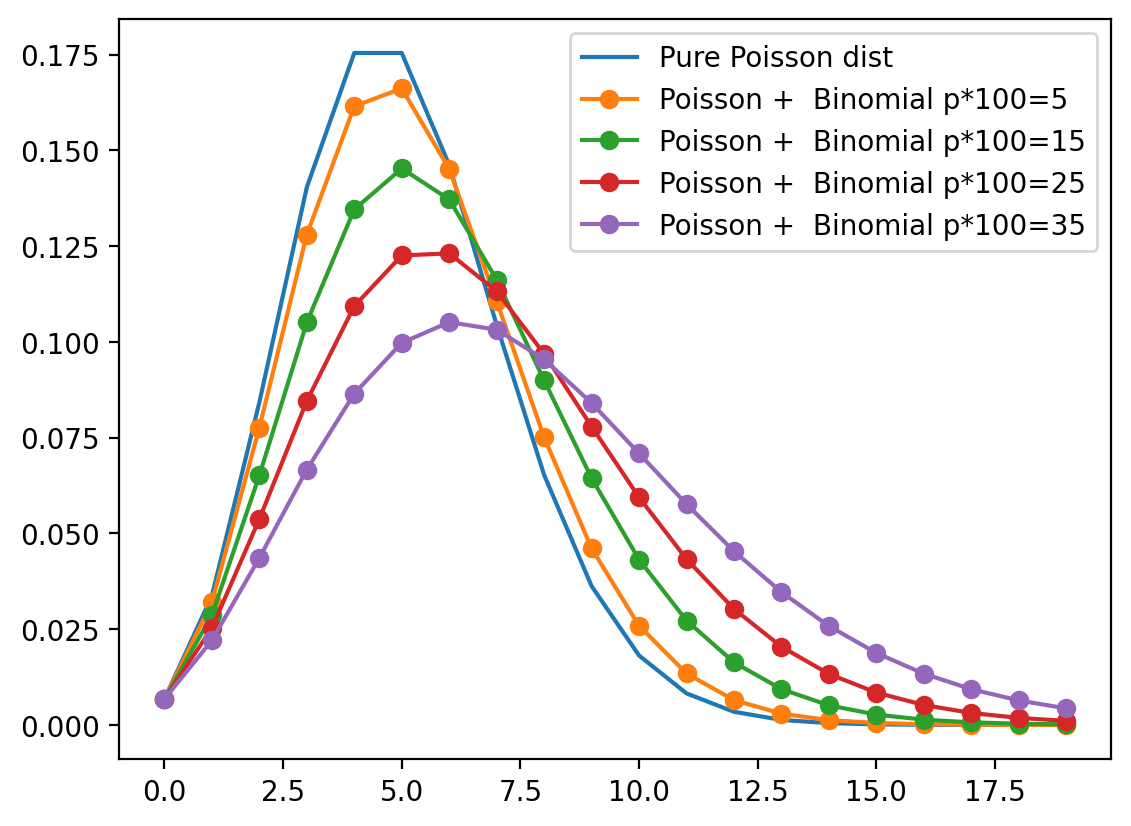

In [13]:
L=5
x=poisson.pmf(range(20), mu=L)

plt.figure(dpi=200)
plt.plot(x,label="Pure Poisson dist")
for ct in np.arange(0.05,.4,0.1):
    # x=[F(i,ct,L) for i in range(20)]
    x=PoissonPlusBinomial(range(20), ct, L)
    plt.plot(x,'o-',label="Poisson +  Binomial p*100="+str(int(ct*100)) )

plt.legend()